In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from collections import Counter

import matplotlib.pyplot as plt
import time
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.expand_frame_repr', False)  # Prevent DataFrame output from wrapping to the next line
pd.options.display.float_format = '{:,.2f}'.format

In [12]:
train_weather = pd.read_parquet('/app/data/train_with_weather_cleaned_20240514.parquet', engine='fastparquet')
test_weather = pd.read_parquet('/app/data/test_with_weather_cleaned_20240514.parquet', engine='fastparquet')

# Drop 'Date' from both train and test datasets
train_weather = train_weather.drop('Date', axis=1)
test_weather = test_weather.drop('Date', axis=1)

train_weather = train_weather.drop('Year', axis=1)
test_weather = test_weather.drop('Year', axis=1)

# Separate the target variable
X_train = train_weather.drop('WnvPresent', axis=1)
y_train = train_weather['WnvPresent']

# Split training data into training and validation
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(X_train, y_train, test_size=.3, random_state=42)

# Ensures each fold is representative of the overall class distribution
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

default_models = {
    'RandomForestClassifier':RandomForestClassifier(), 
    'XGBClassifier': xgb.XGBClassifier(), 
    'LogisticRegression': make_pipeline(StandardScaler(), LogisticRegression(penalty='elasticnet', l1_ratio=0.5, C=1.0, solver='saga', max_iter=1000)),
    'GaussianNB': GaussianNB(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(algorithm='SAMME')
}

In [13]:
### BASIC MODEL SELECTION WITH ADDITIONAL METRICS ###

results_df = pd.DataFrame(columns=['Model', 'ROC Mean', 'ROC Var', 'Precision', 'Recall', 'F1 Score', 'Confusion Matrix'])

for name, model in default_models.items():
    
    # Lists to store per-fold results
    roc_aucs = []
    precisions = []
    recalls = []
    f1s = []
    train_times = []
    pred_times = []
    conf_matrices = []
    
    # Cross-validation loop
    for train_idx, val_idx in cv.split(X_train_o, y_train_o):
        
        # Use X_train_o to make new train and val datasets.
        X_train_add, X_val_add = X_train_o.iloc[train_idx], X_train_o.iloc[val_idx]
        y_train_add, y_val_add = y_train_o.iloc[train_idx], y_train_o.iloc[val_idx]
        
        # Timing model training and prediction
        start_train_time = time.time()
        model.fit(X_train_add, y_train_add)
        elapsed_train_time = time.time() - start_train_time

        start_pred_time = time.time()
        predictions = model.predict(X_val_add)
        probs = model.predict_proba(X_val_add)[:, 1]
        elapsed_pred_time = time.time() - start_pred_time
        
        # Store time
        train_times.append(elapsed_train_time)
        pred_times.append(elapsed_pred_time)
        
        # Calculate and store metrics
        roc_aucs.append(roc_auc_score(y_val_add, probs))
        precisions.append(precision_score(y_val_add, predictions, zero_division=0))
        recalls.append(recall_score(y_val_add, predictions))
        f1s.append(f1_score(y_val_add, predictions))
        conf_matrices.append(confusion_matrix(y_val_add, predictions))
    
    # ROC: Distinguish between different classes: higher values -> better distinction
    # Precision: High if predicts a mosquito specimen is infected and it is. Low wastes money testing mosquitoes that are not carrying the virus.
    # Recall: High if detects most positive cases correctly, i.e. most actual infected mosquitoes (no missed positives). Crucial for public health.

    # Average results from all folds
    avg_results = pd.DataFrame({
        'Model': [name],
        'ROC Mean': [np.mean(roc_aucs)],
        'ROC Var': [np.std(roc_aucs)],
        'Precision': [np.mean(precisions)],
        'Recall': [np.mean(recalls)],
        'F1 Score': [np.mean(f1s)],
        'Training Time': [np.mean(train_times)],
        'Prediction Time': [np.mean(pred_times)],
        'Confusion Matrix': [np.rint(np.mean(conf_matrices, axis=0)).astype(int)]
    })
    
    # print(f"{avg_results['Model']} Average ROC AUC: {avg_results['ROC Mean']} +/- {avg_results['ROC Var']}")
    print(f"Mean/STD: {avg_results['ROC Mean'].iloc[0]:.3f} +/- {avg_results['ROC Var'].iloc[0]:.3f} - {avg_results['Model'].iloc[0]}")

    # Append to results_df
    results_df = pd.concat([results_df, avg_results], ignore_index=True)

# Display results
print(results_df.set_index('Model'))

"""
Precision should be high to avoid wasting money testing mosquitoes that are not carrying the virus.
Recall should be high to detect most infected mosquitoes (no missed positives) which is crucial for public health.
Select the best F1 Score when Precision and Recall are equally important.
A high ROC AUC score means the model can identify infected mosquitoes (high recall) while keeping the number of false positives low (high precision).
AdaBoostClassifier and LogisticRegression have the highest ROC AUC but bad F1 Score. XGBClassifier has a high average ROC AUC and F1 Score.
"""


Mean/STD: 0.824 +/- 0.040 - RandomForestClassifier


/tmp/ipykernel_978/2370184949.py:65: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, avg_results], ignore_index=True)


Mean/STD: 0.848 +/- 0.023 - XGBClassifier
Mean/STD: 0.868 +/- 0.027 - LogisticRegression
Mean/STD: 0.784 +/- 0.032 - GaussianNB
Mean/STD: 0.628 +/- 0.031 - DecisionTreeClassifier
Mean/STD: 0.869 +/- 0.022 - AdaBoostClassifier
                        ROC Mean  ROC Var  Precision  Recall  F1 Score        Confusion Matrix  Training Time  Prediction Time
Model                                                                                                                         
RandomForestClassifier      0.82     0.04       0.31    0.13      0.18    [[686, 11], [34, 5]]           0.52             0.01
XGBClassifier               0.85     0.02       0.33    0.16      0.22    [[684, 13], [32, 6]]           0.14             0.01
LogisticRegression          0.87     0.03       0.45    0.07      0.12     [[693, 3], [36, 3]]           1.18             0.01
GaussianNB                  0.78     0.03       0.11    0.75      0.20  [[475, 222], [10, 29]]           0.01             0.00
DecisionTree

'\nPrecision should be high to avoid wasting money testing mosquitoes that are not carrying the virus.\nRecall should be high to detect most infected mosquitoes (no missed positives) which is crucial for public health.\nSelect the best F1 Score when Precision and Recall are equally important.\nA high ROC AUC score means the model can identify infected mosquitoes (high recall) while keeping the number of false positives low (high precision).\nAdaBoostClassifier and LogisticRegression have the highest ROC AUC but bad F1 Score. XGBClassifier has a high average ROC AUC and F1 Score.\n'

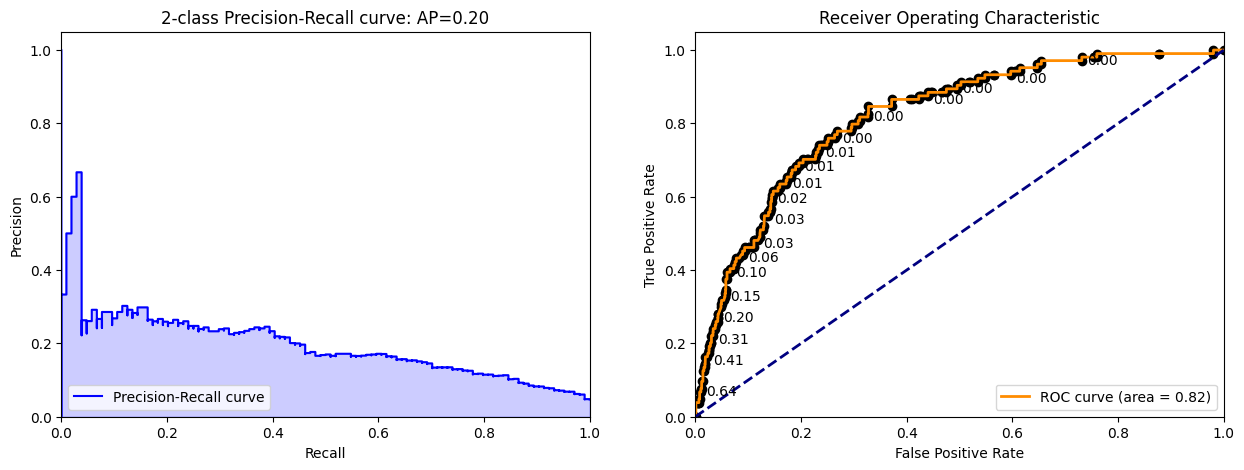

'\nROC curve: To correctly identifies ~100% of the true positives (cases where mosquitoes are infected), the model would \nincorrectly identifying >80% of the negatives as positives. For a TPR >80%, FPR would be >24% with a threshold <0.84%.\n'

In [17]:
### PLOT THE ROC AUC AND PRECISION-RECALL CURVES FOR XGBClassifier ###

X_train_c, X_val_c, y_train_c, y_val_c = train_test_split(X_train_o, y_train_o, test_size=.3, random_state=42)

# Further testing XGBClassifier. Close to best ROC AUC. Best F1 Score (balance between Precision and Recall).
default_models['XGBClassifier'].fit(X_train_c, y_train_c)

# Predict probabilities and classes
y_probs = default_models['XGBClassifier'].predict_proba(X_val_c)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, roc_thresholds = roc_curve(y_val_c, y_probs)
roc_auc = auc(fpr, tpr)

# Compute precision-recall pairs for different probability thresholds
precision, recall, pr_thresholds = precision_recall_curve(y_val_c, y_probs)
average_precision = average_precision_score(y_val_c, y_probs)

plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
plt.step(recall, precision, where='post', color='b', label='Precision-Recall curve')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'2-class Precision-Recall curve: AP={average_precision:.2f}')
plt.legend(loc="lower left")

# ROC curve plot
plt.subplot(1,2,2)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr, tpr, marker='o', color='black')  # mark each threshold
for i, threshold in enumerate(roc_thresholds):
    if i % 11 == 0:
        plt.annotate(f"{threshold:.2f}", (fpr[i]+0.01, tpr[i]-0.02))  # annotate thresholds
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# print(pd.DataFrame(default_models['XGBClassifier'].feature_importances_, index=X_val_c.columns).sort_values(by=0, ascending=False))

# for i, threshold in enumerate(roc_thresholds):
#     if tpr[i] > 0.8:
#         print(f"tpr: {tpr[i]:.4f} fpr: {fpr[i]:.4f} threshold: {threshold:.4f}")  # annotate thresholds
"""
ROC curve: To correctly identifies ~100% of the true positives (cases where mosquitoes are infected), the model would 
incorrectly identifying >80% of the negatives as positives. For a TPR >80%, FPR would be >24% with a threshold <0.84%.
"""

Original dataset shape Counter({0: 4866, 1: 281})
Resampled dataset shape Counter({1: 4280, 0: 4142})


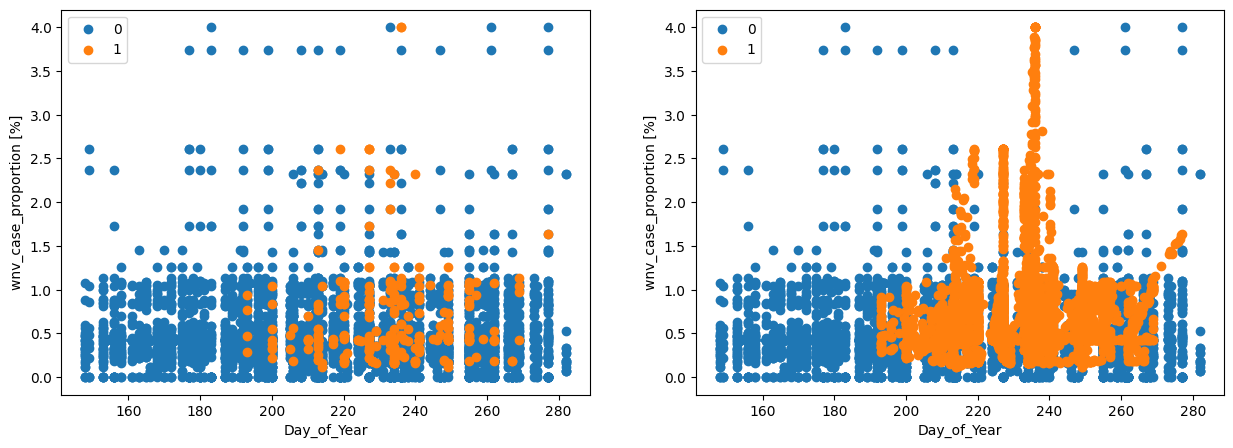

In [15]:
### BALANCED CLASSES ###

X_train_b, X_val_b, y_train_b, y_val_b = train_test_split(X_train_o, y_train_o, test_size=.3, random_state=42)

# Counting class distribution
class_counts = Counter(y_train_b)
print(f'Original dataset shape {class_counts}')

# SMOTEENN oversamples the minority class and undersamples the majority class
X_train_b_float = X_train_b.astype(float)
oversample = SMOTEENN(random_state=0)
X_resampled, y_resampled = oversample.fit_resample(X_train_b_float, y_train_b)

print(f'Resampled dataset shape {Counter(y_resampled)}')

plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
for label in class_counts.keys():
    row_ix = np.where(y_train_b == label)[0]
    plt.scatter(X_train_b['Day_of_Year'].iloc[row_ix], X_train_b['wnv_case_proportion'].iloc[row_ix] * 100, label=str(label))
plt.xlabel("Day_of_Year")
plt.ylabel("wnv_case_proportion [%]")
plt.legend()

plt.subplot(1,2,2)
for label_resampled in class_counts.keys():
    row_ix_resampled = np.where(y_resampled == label_resampled)[0]
    plt.scatter(X_resampled['Day_of_Year'].iloc[row_ix_resampled], X_resampled['wnv_case_proportion'].iloc[row_ix_resampled] * 100, label=str(label_resampled))
plt.xlabel("Day_of_Year")
plt.ylabel("wnv_case_proportion [%]")
plt.legend()

plt.show()

In [18]:
### MODEL SELECTION USING BALANCED DATASET ###

results_df = pd.DataFrame(columns=['Model', 'ROC Mean', 'ROC Var', 'Precision', 'Recall', 'F1 Score', 'Confusion Matrix'])

for name, model in default_models.items():

    # Lists to store per-fold results
    roc_aucs = []
    precisions = []
    recalls = []
    f1s = []
    train_times = []
    pred_times = []
    conf_matrices = []
    
    # Cross-validation loop
    for train_idx, val_idx in cv.split(X_train_o, y_train_o):
        # Original training and validation sets
        X_train_orig, X_val_orig = X_train_o.iloc[train_idx], X_train_o.iloc[val_idx]
        y_train_orig, y_val_orig = y_train_o.iloc[train_idx], y_train_o.iloc[val_idx]

        # Resample the training data only
        X_train_orig_float = X_train_orig.astype(float)
        oversample = SMOTEENN(random_state=0)
        X_resampled, y_resampled = oversample.fit_resample(X_train_orig_float, y_train_orig)

        # Timing model training and prediction
        start_train_time = time.time()
        model.fit(X_resampled, y_resampled)
        elapsed_train_time = time.time() - start_train_time

        start_pred_time = time.time()
        predictions = model.predict(X_val_orig)
        probs = model.predict_proba(X_val_orig)[:, 1]
        elapsed_pred_time = time.time() - start_pred_time
        
        # Store time
        train_times.append(elapsed_train_time)
        pred_times.append(elapsed_pred_time)
        
        # Calculate and store metrics
        roc_aucs.append(roc_auc_score(y_val_orig, probs))
        precisions.append(precision_score(y_val_orig, predictions, zero_division=0))
        recalls.append(recall_score(y_val_orig, predictions))
        f1s.append(f1_score(y_val_orig, predictions))
        conf_matrices.append(confusion_matrix(y_val_orig, predictions))
    
    # ROC: Distinguish between different classes: higher values -> better distinction
    # Precision: High if predicts a mosquito specimen is infected and it is. Low wastes money testing mosquitoes that are not carrying the virus.
    # Recall: High if detects most positive cases correctly, i.e. most actual infected mosquitoes (no missed positives). Crucial for public health.

    # Average results from all folds
    avg_results = pd.DataFrame({
        'Model': [name],
        'ROC Mean': [np.mean(roc_aucs)],
        'ROC Var': [np.std(roc_aucs)],
        'Precision': [np.mean(precisions)],
        'Recall': [np.mean(recalls)],
        'F1 Score': [np.mean(f1s)],
        'Training Time': [np.mean(train_times)],
        'Prediction Time': [np.mean(pred_times)],
        'Confusion Matrix': [np.rint(np.mean(conf_matrices, axis=0)).astype(int)]
    })
    
    # print(f"{avg_results['Model']} Average ROC AUC: {avg_results['ROC Mean']} +/- {avg_results['ROC Var']}")
    print(f"Mean/STD: {avg_results['ROC Mean'].iloc[0]:.3f} +/- {avg_results['ROC Var'].iloc[0]:.3f} - {avg_results['Model'].iloc[0]}")

    # Append to results_df
    results_df = pd.concat([results_df, avg_results], ignore_index=True)

# Display results
print(results_df.set_index('Model'))

"""
Using the balanced dataset to train while validating on the unbalanced dataset, the models perform similarly on the ROC AUC score
but this time the F1 Score is higher across the board. AdaBoostClassifier has the highest average ROC AUC, F1 Score that 
balances Precision and Recall quite well, and a high Recall. The confusion matrix shows that all models do a better job at predicting positive cases using
the balanced dataset for training.
"""

Mean/STD: 0.824 +/- 0.041 - RandomForestClassifier


/tmp/ipykernel_978/264875451.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, avg_results], ignore_index=True)


Mean/STD: 0.848 +/- 0.028 - XGBClassifier
Mean/STD: 0.864 +/- 0.027 - LogisticRegression
Mean/STD: 0.781 +/- 0.032 - GaussianNB
Mean/STD: 0.677 +/- 0.034 - DecisionTreeClassifier
Mean/STD: 0.870 +/- 0.024 - AdaBoostClassifier
                        ROC Mean  ROC Var  Precision  Recall  F1 Score        Confusion Matrix  Training Time  Prediction Time
Model                                                                                                                         
RandomForestClassifier      0.82     0.04       0.26    0.47      0.34   [[645, 52], [20, 18]]           2.28             0.01
XGBClassifier               0.85     0.03       0.27    0.47      0.34   [[648, 49], [20, 18]]           0.33             0.01
LogisticRegression          0.86     0.03       0.16    0.80      0.26   [[530, 167], [8, 31]]           2.58             0.00
GaussianNB                  0.78     0.03       0.10    0.80      0.18   [[431, 266], [8, 31]]           0.02             0.00
DecisionTree

'\nUsing the balanced dataset to train while validating on the unbalanced dataset, the models perform similarly on the ROC AUC score\nbut this time the F1 Score is higher across the board. AdaBoostClassifier has the highest average ROC AUC, F1 Score that \nbalances Precision and Recall quite well, and a high Recall. The confusion matrix shows that all models do a better job at predicting positive cases using\nthe balanced dataset for training.\n'

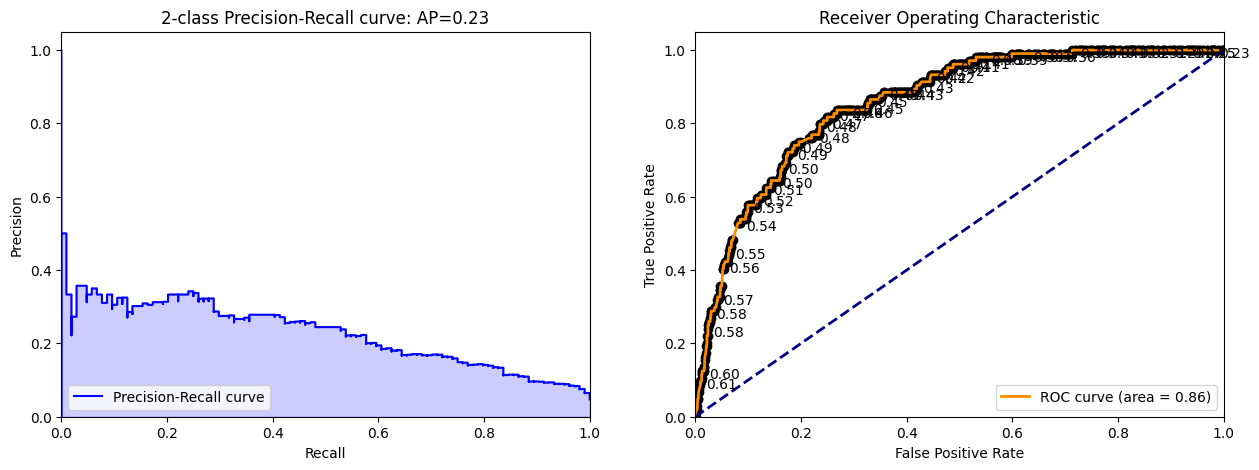

                    Feature  Importance
14      wnv_case_proportion        0.16
6              NumMosquitos        0.13
0                   Species        0.13
9                     Month        0.10
24                  Sunrise        0.07
46     StnPressure_7day_avg        0.06
39            DewPoint_lag1        0.06
16                     Tmax        0.05
31                ResultDir        0.04
12         Location_Cluster        0.04
43         PrecipTotal_lag1        0.04
15  wnv_case_proportion_alt        0.03
8              Week_of_Year        0.03
7               Day_of_Year        0.03
3                  Latitude        0.02
13      mosquito_proportion        0.01
23                     Cool        0.01
50       ResultDir_7day_avg        0.00
45         StnPressure_lag1        0.00
44     PrecipTotal_7day_avg        0.00
33                Tmax_lag1        0.00
42         WetBulb_7day_avg        0.00
41             WetBulb_lag1        0.00
49           ResultDir_lag1        0.00


In [19]:
### PLOT THE ROC AUC AND PRECISION-RECALL CURVES ###

X_train_c, X_val_c, y_train_c, y_val_c = train_test_split(X_train_o, y_train_o, test_size=.3, random_state=42)

# Resample the training data only
X_train_c_float = X_train_c.astype(float)
oversample = SMOTEENN(random_state=0)
X_resampled, y_resampled = oversample.fit_resample(X_train_c_float, y_train_c)

# Final choice: AdaBoostClassifier. Highest ROC AUC. Good Precision and Recall balance
default_models['AdaBoostClassifier'].fit(X_resampled, y_resampled)

# Predict probabilities and classes
y_probs = default_models['AdaBoostClassifier'].predict_proba(X_val_c)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, roc_thresholds = roc_curve(y_val_c, y_probs)
roc_auc = auc(fpr, tpr)

# Compute precision-recall pairs for different probability thresholds
precision, recall, pr_thresholds = precision_recall_curve(y_val_c, y_probs)
average_precision = average_precision_score(y_val_c, y_probs)

plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
plt.step(recall, precision, where='post', color='b', label='Precision-Recall curve')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'2-class Precision-Recall curve: AP={average_precision:.2f}')
plt.legend(loc="lower left")

# ROC curve plot
plt.subplot(1,2,2)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr, tpr, marker='o', color='black')  # mark each threshold
for i, threshold in enumerate(roc_thresholds):
    if i % 11 == 0:
        plt.annotate(f"{threshold:.2f}", (fpr[i]+0.01, tpr[i]-0.02))  # annotate thresholds
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

feature_importances = pd.DataFrame({
    'Feature': X_val_c.columns,
    'Importance': default_models['AdaBoostClassifier'].feature_importances_
}).sort_values(by='Importance', ascending=False)  # Sorting the features by importance

# Displaying the DataFrame
print(feature_importances)

# for i, threshold in enumerate(roc_thresholds):
#     if tpr[i] > 0.8:
#         print(f"tpr: {tpr[i]:.4f} fpr: {fpr[i]:.4f} threshold: {threshold:.4f}")  # annotate thresholds